In [931]:
#boundry detection LSTMS+ CV

In [ ]:
#variable length model

In [426]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Set your sequence directory path
sequence_dir = './keypoints'   # Replace with your actual path

# 1. Data Loading and Analysis
features = [] 
labels = []



In [427]:
print("Loading and processing sequences...")
for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                features.append(keypoints_sequence)
                labels.append(word_folder)
print(f"Loaded {len(features)} sequences")

Loading and processing sequences...
Loaded 8437 sequences


In [428]:
# Calculate sequence length statistics
sequence_lengths = [len(seq) for seq in features]
avg_length = np.mean(sequence_lengths)
percentile_95 = np.percentile(sequence_lengths, 95)
optimal_max_length = int(percentile_95) + 3  # 95th percentile + small buffer

print(f"\nSequence Length Analysis:")
print(f"Total sequences: {len(features)}")
print(f"Average length: {avg_length:.1f} frames")
print(f"95th percentile: {percentile_95:.1f} frames")
print(f"Maximum length: {max(sequence_lengths)} frames")
print(f"\nUsing optimal max length: {optimal_max_length} frames")
print(f"This will truncate {sum(1 for l in sequence_lengths if l > optimal_max_length)} sequences ({len(features)} total)")


Sequence Length Analysis:
Total sequences: 8437
Average length: 73.0 frames
95th percentile: 102.0 frames
Maximum length: 238 frames

Using optimal max length: 105 frames
This will truncate 315 sequences (8437 total)


In [429]:
# 2. Data Preprocessing
# Pad/truncate sequences
X = pad_sequences(features, 
                 maxlen=optimal_max_length, 
                 padding='post', 
                 truncating='post', 
                 dtype='float32')

In [430]:
from joblib import dump
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print(f"\nShape after padding: {X.shape}")
print(f"Number of classes: {num_classes}")
print("Class labels:", label_encoder.classes_)
dump(label_encoder, 'label_encoder.joblib')
print("Label encoder saved to 'label_encoder.joblib'")


Shape after padding: (8437, 105, 258)
Number of classes: 20
Class labels: ['baby' 'eat' 'father' 'finish' 'good' 'happy' 'hear' 'house' 'important'
 'love' 'mall' 'me' 'mosque' 'mother' 'normal' 'sad' 'stop' 'thanks'
 'thinking' 'worry']
Label encoder saved to 'label_encoder.joblib'


In [431]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Training samples: 6749, Test samples: 1688


In [441]:
# 4. Model Architecture
print("\nBuilding optimized LSTM model...")
model = Sequential([
    Masking(mask_value=0., input_shape=(optimal_max_length, X_train.shape[2])),
    Bidirectional(LSTM(64, return_sequences=True, activation='tanh')),
    tf.keras.layers.Dropout(0.3),  # Add 30% dropout
    Bidirectional(LSTM(128, activation='tanh')),
    tf.keras.layers.Dropout(0.3),  # Add 30% dropout
    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Add 30% dropout
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Building optimized LSTM model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)             │ (None, 105, 258)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 105, 128)       │       165,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 105, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 464,020 (1.77 MB)

 Trainable params: 464,020 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [443]:
# 5. Training Configuration
model_save_path = 'optimized_LSTM_model.keras'
callbacks = [
    ModelCheckpoint(model_save_path, save_best_only=True),
    EarlyStopping(patience=5, restore_best_weights=True),
    TensorBoard(log_dir='logs_optimized')
]

# 6. Training
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Training model...
Epoch 1/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - accuracy: 0.6442 - loss: 0.9026 - val_accuracy: 0.6842 - val_loss: 0.7748
Epoch 2/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.6835 - loss: 0.8116 - val_accuracy: 0.7530 - val_loss: 0.6265
Epoch 3/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - accuracy: 0.7225 - loss: 0.7242 - val_accuracy: 0.7891 - val_loss: 0.5229
Epoch 4/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.7613 - loss: 0.6124 - val_accuracy: 0.7767 - val_loss: 0.5593
Epoch 5/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.7928 - loss: 0.5591 - val_accuracy: 0.8389 - val_loss: 0.4426
Epoch 6/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - accuracy: 0.7932 - loss: 0.5580 - val_accuracy: 0.8537 - val_loss: 0.3766
Epoch 7/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.8101 - loss: 0.5046 - val_accuracy: 0.8738 - val_loss: 0.3481
Epoch 8/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - accurac


Evaluating model...
Test Accuracy: 95.38%
Test Loss: 0.1355
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step


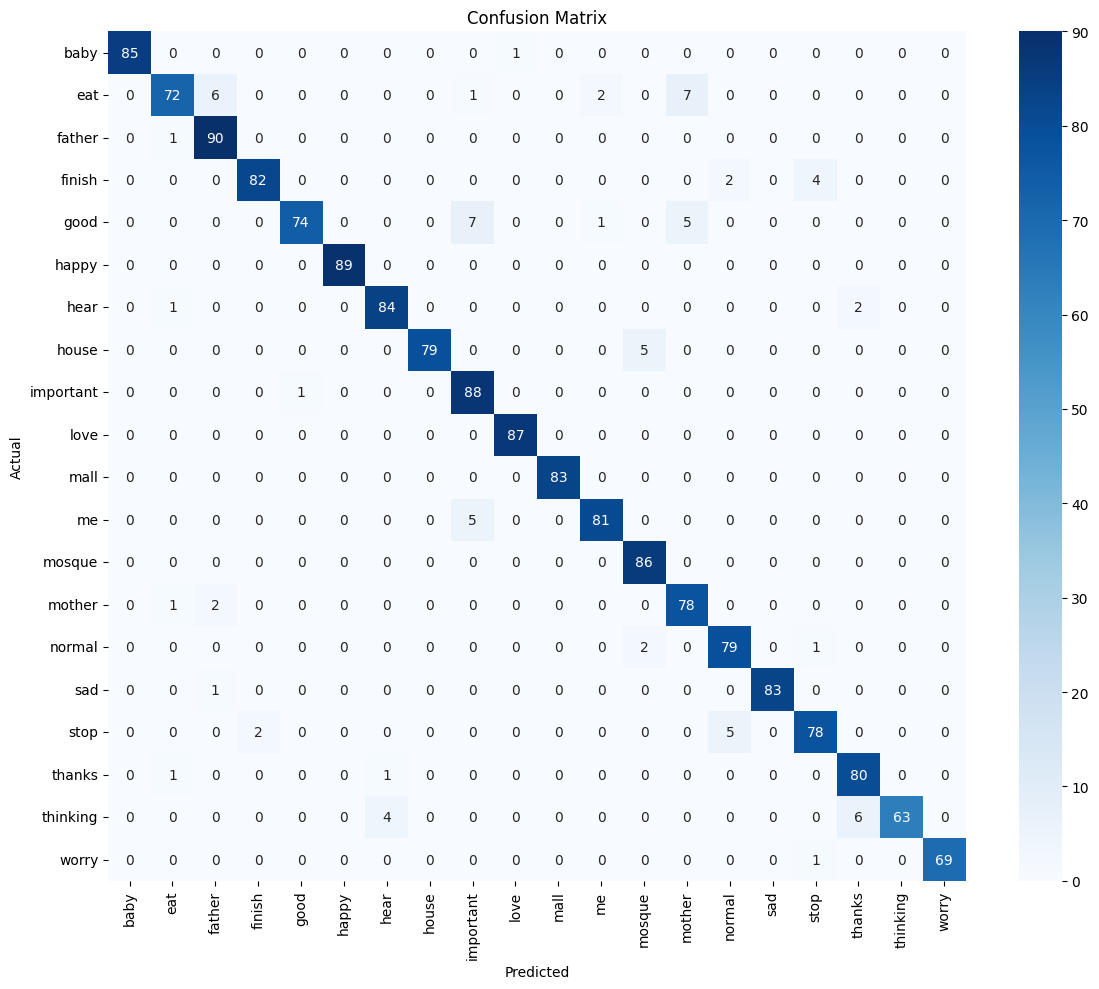


Classification Report:
              precision    recall  f1-score   support

        baby       1.00      0.99      0.99        86
         eat       0.95      0.82      0.88        88
      father       0.91      0.99      0.95        91
      finish       0.98      0.93      0.95        88
        good       0.99      0.85      0.91        87
       happy       1.00      1.00      1.00        89
        hear       0.94      0.97      0.95        87
       house       1.00      0.94      0.97        84
   important       0.87      0.99      0.93        89
        love       0.99      1.00      0.99        87
        mall       1.00      1.00      1.00        83
          me       0.96      0.94      0.95        86
      mosque       0.92      1.00      0.96        86
      mother       0.87      0.96      0.91        81
      normal       0.92      0.96      0.94        82
         sad       1.00      0.99      0.99        84
        stop       0.93      0.92      0.92        85
   

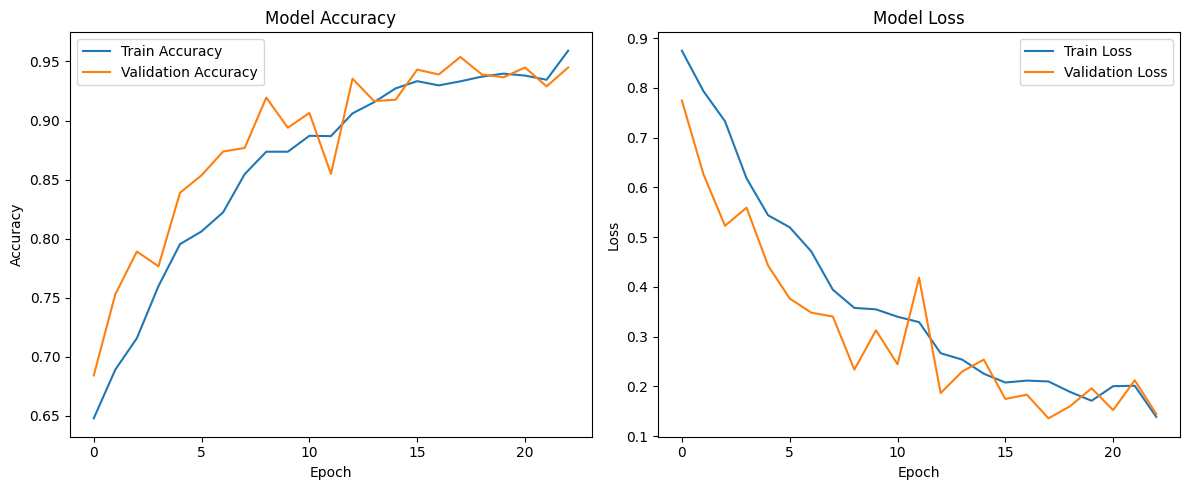


Training completed. Model saved to: optimized_LSTM_model.keras


In [444]:
# 7. Evaluation
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
plt.figure(figsize=(12, 10))
conf_mat = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Training History Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("\nTraining completed. Model saved to:", model_save_path)

In [ ]:
#testing model on its own

In [186]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image, ImageDraw, ImageFont
import arabic_reshaper
from bidi.algorithm import get_display

# Initialize MediaPipe Holistic
mp_holistic = mp.solutions.holistic

# Load your trained model
model = load_model('optimized_LSTM_model.keras')

# Define label classes
label_classes = [
    'baby', 'eat', 'father', 'finish', 'good', 'happy', 'hear', 'house',
    'important', 'love', 'mall', 'me', 'mosque', 'mother', 'normal', 'sad',
    'stop', 'thanks', 'thinking', 'worry'
]

# Arabic conversion
def convert_to_arabic(english_word):
    arabic_dict = {
       'baby': 'طفل', 'eat': 'يأكل', 'father': 'أب', 'finish': 'ينهي', 'good': 'جيد',
        'happy': 'سعيد', 'hear': 'يسمع', 'house': 'منزل', 'important': 'مهم',
        'love': 'حب', 'mall': 'مركز تجاري', 'me': 'أنا', 'mosque': 'مسجد', 'mother': 'أم',
        'normal': 'عادي', 'sad': 'حزين', 'stop': 'توقف', 'thanks': 'شكرا',
        'thinking': 'يفكر', 'worry': 'قلق'
    } 
    return arabic_dict.get(english_word.lower(), english_word)

# Mediapipe utils
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

# Core video processing function
def process_video(video_path):
    optimal_max_length = 105
    threshold = 0.5
    sequence = []
    sentence = []

# Process a list of videos
video_paths = ["My_Videos/Saved_clips/vid1.mp4","My_Videos/Saved_clips/vid2.mp4","My_Videos/Saved_clips/vid3.mp4",
               "My_Videos/Saved_clips/vid4.mp4","My_Videos/Saved_clips/vid5.mp4"]
#video_paths = ["My_Videos/z/Babyz.mp4", "My_Videos/z/eatz.mp4","My_Videos/z/fatherz.mp4","My_Videos/z/finishz.mp4","My_Videos/z/goodz.mp4","My_Videos/z/happyz.mp4","My_Videos/z/heaz.mp4","My_Videos/z/housez.mp4","My_Videos/z/importantz.mp4","My_Videos/z/lovez.mp4","My_Videos/z/mallz.mp4","My_Videos/z/mez.mp4","My_Videos/z/mosquez.mp4","My_Videos/z/motherz.mp4","My_Videos/z/normalz.mp4","My_Videos/z/sadz1.mp4","My_Videos/z/sadz2.mp4","My_Videos/z/stop.mp4","My_Videos/z/thanksz.mp4","My_Videos/z/thinkingz.mp4","My_Videos/z/worryz.mp4"]

# Initialize lists to track accepted and rejected clips
accepted_clips = []
rejected_clips = []

for path in video_paths:
    optimal_max_length = 105
    threshold = 0.5
    sequence = []
    sentence = []

    cap = cv2.VideoCapture(path)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            image, results = mediapipe_detection(frame, holistic)
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-optimal_max_length:]

            if len(sequence) == optimal_max_length:
                padded_sequence = pad_sequences([sequence], maxlen=optimal_max_length, padding='post', truncating='post', dtype='float32')
                res = model.predict(padded_sequence)[0]
                predicted_index = np.argmax(res)
                confidence = res[predicted_index]
                predicted_word = label_classes[predicted_index]

                if confidence >= threshold:
                    arabic_equivalent = convert_to_arabic(predicted_word)
                    if not sentence or arabic_equivalent != sentence[-1]:
                        sentence.append(arabic_equivalent)
                    full_sentence = ' '.join(sentence)

                    reshaped_text = arabic_reshaper.reshape(full_sentence)
                    bidi_text = get_display(reshaped_text)

                    img_pil = Image.fromarray(image)
                    draw = ImageDraw.Draw(img_pil)
                    try:
                        font = ImageFont.truetype("arial.ttf", 32)
                    except:
                        font = ImageFont.load_default()

                    draw.text((50, 30), bidi_text, font=font, fill=(255, 255, 255))
                    draw.text((50, 70), f"Confidence: {confidence*100:.1f}%", font=font, fill=(255, 255, 255))
                    draw.text((50, 110), f"English: {predicted_word}", font=font, fill=(255, 255, 255))
                    image = np.array(img_pil)
                else:
                    cv2.putText(image, f"Low confidence: {confidence*100:.1f}%", (50, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.imshow('Arabic Sign Language Recognition', image)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

    # Final prediction summary
    if len(sequence) >= 10:
        padded_sequence = pad_sequences([sequence], maxlen=optimal_max_length, padding='post', truncating='post', dtype='float32')
        res = model.predict(padded_sequence)[0]
        predicted_index = np.argmax(res)
        confidence = res[predicted_index]
        predicted_word = label_classes[predicted_index]

        print(f"\n[RESULT for '{path}']")
        if confidence >= threshold:
            arabic_equivalent = convert_to_arabic(predicted_word)
            print("Arabic:", arabic_equivalent)
            print("English:", predicted_word)
            print(f"Confidence: {confidence * 100:.1f}%")
            accepted_clips.append(path)
        else:
            print("No high-confidence predictions detected")
            print(f"Highest confidence was: {confidence * 100:.1f}%")
            rejected_clips.append(path)
    else:
        print(f"\n[RESULT for '{path}']")
        print("Video is too short for prediction (less than 30 frames).")
        rejected_clips.append(path)

# Print final summary of accepted and rejected clips
print("\n" + "="*50)
print("Accepted clips are:", ", ".join(accepted_clips))
print("Rejected clips are:", ", ".join(rejected_clips))
print("="*50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step

[RESULT for 'My_Videos/Saved_clips/vid1.mp4']
Arabic: توقف
English: stop
Confidence: 84.9%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

[RESULT for 'My_Videos/Saved_clips/vid2.mp4']
Arabic: توقف
English: stop
Confidence: 89.4%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

[RESULT for 'My_Videos/Saved_clips/vid3.mp4']
Arabic: توقف
English: stop
Confidence: 88.6%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

[RESULT for 'My_Videos/Saved_clips/vid4.mp4']
Arabic: توقف
English: stop
Confidence: 81.1%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

[RESULT for 'My_Videos/Saved_clips/vid5.mp4']
No high-confidence predictions detected
Highest confidence was: 42.4%

Accepted clips are: My_Videos/Saved_clips/vid1.mp4, My_Videos/Saved_clips/vid2.mp4, My_Videos/Saved_clips/vid3.mp4, My_Videos/Saved_clips/vid4.mp4
Rejected clips are: My_Videos/Saved_clips/vid5.mp4


In [ ]:
#analaysis for the dataset


Sequence Length Analysis:
Average length: 73.0 frames
Median length: 71.0 frames
90th percentile: 94.0 frames
95th percentile: 102.0 frames
Maximum length: 238 frames


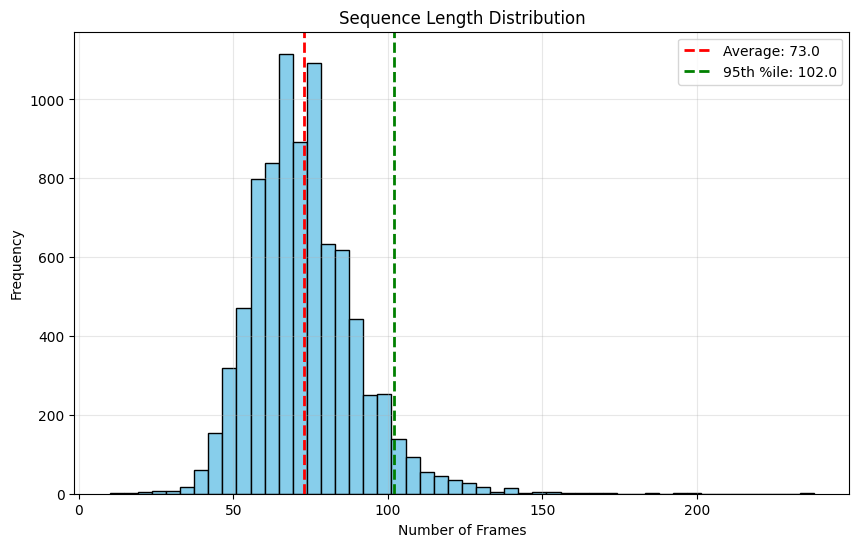


Recommended max length (95th %ile + buffer): 112

Shape after padding: (8437, 112, 258)
Original number of sequences: 8437
Will truncate 198 sequences


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate length statistics
sequence_lengths = [len(seq) for seq in features]
avg_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
percentile_90 = np.percentile(sequence_lengths, 90)
percentile_95 = np.percentile(sequence_lengths, 95)

print("\nSequence Length Analysis:")
print(f"Average length: {avg_length:.1f} frames")
print(f"Median length: {median_length:.1f} frames")
print(f"90th percentile: {percentile_90:.1f} frames")
print(f"95th percentile: {percentile_95:.1f} frames")
print(f"Maximum length: {max_length} frames")

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(avg_length, color='red', linestyle='dashed', linewidth=2, label=f'Average: {avg_length:.1f}')
plt.axvline(percentile_95, color='green', linestyle='dashed', linewidth=2, label=f'95th %ile: {percentile_95:.1f}')
plt.title('Sequence Length Distribution')
plt.xlabel('Number of Frames')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Recommended max length calculation (using 95th percentile + buffer)
recommended_max_length = int(percentile_95) + 10
print(f"\nRecommended max length (95th %ile + buffer): {recommended_max_length}")

# Padding with the recommended length
X = pad_sequences(features, 
                 maxlen=recommended_max_length, 
                 padding='post', 
                 truncating='post', 
                 dtype='float32')

print(f"\nShape after padding: {X.shape}")
print(f"Original number of sequences: {len(features)}")
print(f"Will truncate {sum(1 for l in sequence_lengths if l > recommended_max_length)} sequences")